In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.metrics import r2_score
import matplotlib.ticker as mticker
from lmfit.models import PowerLawModel

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset

# Global plot parameters
plt.rcParams.update({'font.size':20, 'lines.markersize':9})
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.family':'Times New Roman'})

In [2]:
def power_fit_lmfit(params, x, y):
        a = params['a']
        b = params['b']
        y_fit = a*x**b
        
        return y_fit-y

def func_powerlaw(x, a, b):
        return a*x**b

In [3]:
def calc_rsquared(x, y, amplitude, exponent):
    yhat = func_powerlaw(x, amplitude, exponent)

    return r2_score(y, yhat)

In [4]:
data_location = Path(r'./motor_data_master.ods')

xlsx = pd.ExcelFile(data_location, engine='odf')

maxon_df = xlsx.parse(sheet_name='Maxon')
servo_df = xlsx.parse(sheet_name='Servos')
stepper_df = xlsx.parse(sheet_name='Stepper')

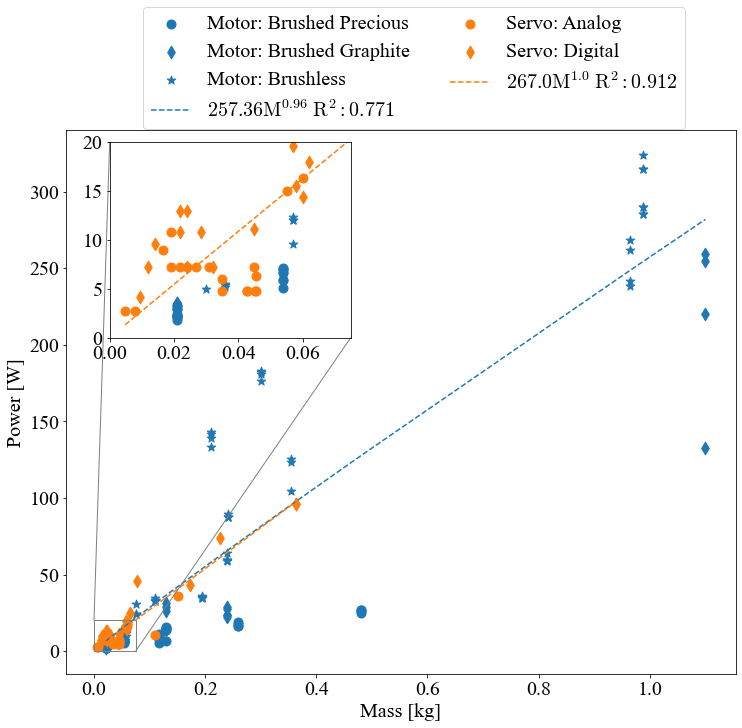

In [8]:
fig1, ax1 = plt.subplots(figsize=(12,10), facecolor='w')

axins = inset_axes(ax1, width="60%", height="60%",
                   bbox_to_anchor=(.05, .6, .6, .6),
                   bbox_transform=ax1.transAxes, loc=3)

motor_types = maxon_df['Type'].unique()
mapping = ['Brushed Precious', 'Brushed Graphite', 'Brushless']
colors = ['tab:blue', 'tab:orange', 'tab:green']
markers = ['o', 'd', '*']


maxon_df.sort_values(by=['Weight [kg]'], inplace=True)
servo_df.sort_values(by=['Weight [kg]'], inplace=True)

model = PowerLawModel(prefix='p_')
maxon_power = np.multiply(maxon_df['Nominal Voltage [V]'].values, maxon_df['Nominal Current [A]'].values)
pars = model.guess(maxon_power, x=maxon_df['Weight [kg]'].values)
pars['p_amplitude'].set(value=50, min=20.0, max=5000.0)
pars['p_exponent'].set(value=3.0, min=0.25, max=5.0)

maxon_fit = model.fit(maxon_power, pars, x=maxon_df['Weight [kg]'].values)

servo_power = np.multiply(servo_df['Nominal Voltage [V]'].values, servo_df['Nominal Current [A]'].values)
pars = model.guess(servo_power, x=servo_df['Weight [kg]'].values)
pars['p_amplitude'].set(value=100.0, min=5.0, max=500.0)
pars['p_exponent'].set(value=3.0, min=0.25, max=5.0)

servo_fit = model.fit(servo_power, pars, x=servo_df['Weight [kg]'].values)

r_squared = np.array([calc_rsquared(maxon_df['Weight [kg]'].values, maxon_power, maxon_fit.params['p_amplitude'], maxon_fit.params['p_exponent']), 
                      calc_rsquared(servo_df['Weight [kg]'].values, servo_power, servo_fit.params['p_amplitude'], servo_fit.params['p_exponent'])])

for i, case in enumerate(motor_types):
    df = maxon_df[maxon_df['Type']==case].copy()
    df.sort_values(by=['Weight [kg]'], inplace=True)
    power = np.multiply(df['Nominal Voltage [V]'].values, df['Nominal Current [A]'].values)
    #fit = np.poly1d(np.polyfit(df['weight [g]'], power, 1))
    ax1.scatter(df['Weight [kg]'], power, marker=markers[i], color='C0', label='Motor: ' + mapping[i])
    #ax1.plot(df['weight [g]'], fit(df['weight [g]']), '--', color=colors[i], label=mapping[i] + ' fit')

    axins.scatter(df['Weight [kg]'], power, marker=markers[i], color='C0', label='Motor: ' + mapping[i])

ax1.plot(maxon_df['Weight [kg]'].values, maxon_fit.params['p_amplitude'].value*maxon_df['Weight [kg]'].values**maxon_fit.params['p_exponent'].value, 'C0' + '--', label='$\mathrm{' + str(np.round(maxon_fit.params['p_amplitude'].value, 2)) + 
        'M^{' + str(np.round(maxon_fit.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(r_squared[0], 3)) + '}$')

servo_types = servo_df['Circuit'].unique()
for i, case in enumerate(servo_types):
    df = servo_df[servo_df['Circuit']==case].copy()
    df.sort_values(by=['Weight [kg]'], inplace=True)
    power = np.multiply(df['Nominal Voltage [V]'].values, df['Nominal Current [A]'].values)
    #fit = np.poly1d(np.polyfit(df['weight [g]'], power, 1))
    ax1.scatter(df['Weight [kg]'], power, marker=markers[i], color='C1', label='Servo: ' + case)
    #ax1.plot(df['weight [g]'], fit(df['weight [g]']), '--', color=colors[i], label=mapping[i] + ' fit')

    axins.scatter(df['Weight [kg]'], power, marker=markers[i], color='C1', label='Servo: ' + case)

ax1.plot(servo_df['Weight [kg]'].values, servo_fit.params['p_amplitude'].value*servo_df['Weight [kg]'].values**servo_fit.params['p_exponent'].value, 'C1' + '--', label='$\mathrm{' + str(np.round(servo_fit.params['p_amplitude'].value, 2)) + 
        'M^{' + str(np.round(servo_fit.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(r_squared[1], 3)) + '}$')
axins.plot(servo_df['Weight [kg]'].values, servo_fit.params['p_amplitude'].value*servo_df['Weight [kg]'].values**servo_fit.params['p_exponent'].value, 'C1' + '--', label='$\mathrm{' + str(np.round(servo_fit.params['p_amplitude'].value, 2)) + 
        'M^{' + str(np.round(servo_fit.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(r_squared[1], 3)) + '}$')

mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")
axins.set_xlim([0, 0.075])
axins.set_ylim([0, 20])

formatter = mticker.ScalarFormatter(useMathText=True, useOffset=False)
formatter.set_scientific(True)
# fix the number of ticks on the inset axes
axins.yaxis.get_major_locator().set_params(nbins=4)
axins.xaxis.get_major_locator().set_params(nbins=4)
#axins.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_xlabel('Mass [kg]')
ax1.set_ylabel('Power [W]')
#ax1.legend(ncol=2, loc=2)
ax1.legend(ncol=2, loc=2, bbox_to_anchor=(0.1, 1.245))
fig1.savefig('motor_power_mass.pdf', facecolor='w', dpi=300, bbox_inches='tight')

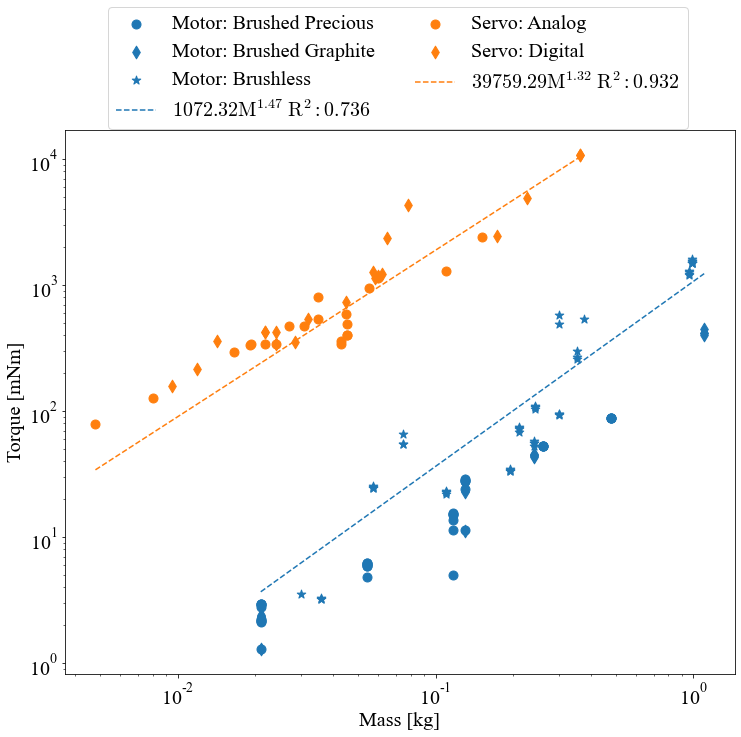

In [9]:
fig2, ax2 = plt.subplots(figsize=(12,10), facecolor='w')
types = maxon_df['Type'].unique()
mapping = ['Brushed Precious', 'Brushed Graphite', 'Brushless']
markers = ['o', 'd', '*']
colors = ['tab:blue', 'tab:orange', 'tab:green']

maxon_df.sort_values(by=['Weight [kg]'], inplace=True)
servo_df.sort_values(by=['Weight [kg]'], inplace=True)

model = PowerLawModel(prefix='p_')
pars = model.guess(maxon_df['Nominal Torque [mNm]'].values, x=maxon_df['Weight [kg]'].values)
pars['p_amplitude'].set(value=50, min=20.0, max=5000.0)
pars['p_exponent'].set(value=3.0, min=1.0, max=5.0)

maxon_fit = model.fit(maxon_df['Nominal Torque [mNm]'].values, pars, x=maxon_df['Weight [kg]'].values)

pars = model.guess(servo_df['Torque [mNm]'].values, x=servo_df['Weight [kg]'].values)
pars['p_amplitude'].set(value=10000.0, min=5000.0, max=50000.0)
pars['p_exponent'].set(value=3.0, min=1.0, max=5.0)

servo_fit = model.fit(servo_df['Torque [mNm]'].values, pars, x=servo_df['Weight [kg]'].values)

r_squared = np.array([calc_rsquared(maxon_df['Weight [kg]'].values, maxon_df['Nominal Torque [mNm]'].values, maxon_fit.params['p_amplitude'], maxon_fit.params['p_exponent']), 
                      calc_rsquared(servo_df['Weight [kg]'].values, servo_df['Torque [mNm]'].values, servo_fit.params['p_amplitude'], servo_fit.params['p_exponent'])])

dx = np.linspace(0.1, 1.0, 20)
for i, case in enumerate(types):
    df = maxon_df[maxon_df['Type']==case].copy()
    df.sort_values(by=['Weight [kg]'], inplace=True)
    #fit = np.poly1d(np.polyfit(df['weight [g]'], df['Nominal Torque [mNm]'], 1))
    ax2.scatter(df['Weight [kg]'], df['Nominal Torque [mNm]'], marker=markers[i], color='C0', label='Motor: ' + mapping[i])
    #ax2.plot(df['weight [g]'], fit(df['weight [g]']), '--', color=colors[i], label=mapping[i] + ' fit')

ax2.plot(maxon_df['Weight [kg]'].values, maxon_fit.params['p_amplitude'].value*maxon_df['Weight [kg]'].values**maxon_fit.params['p_exponent'].value, 'C0' + '--', label='$\mathrm{' + str(np.round(maxon_fit.params['p_amplitude'].value, 2)) + 
        'M^{' + str(np.round(maxon_fit.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(r_squared[0], 3)) + '}$')

servo_types = servo_df['Circuit'].unique()
for i, case in enumerate(servo_types):
    df = servo_df[servo_df['Circuit']==case].copy()
    df.sort_values(by=['Weight [kg]'], inplace=True)
    #fit = np.poly1d(np.polyfit(df['weight [g]'], power, 1))
    ax2.scatter(df['Weight [kg]'], df['Torque [mNm]'], marker=markers[i], color='C1', label='Servo: ' + case)
    #ax1.plot(df['weight [g]'], fit(df['weight [g]']), '--', color=colors[i], label=mapping[i] + ' fit')

    #axins.scatter(df['Weight [kg]'], power, marker='d', color=colors[i], label='Servo: ' + case)

ax2.plot(servo_df['Weight [kg]'].values, servo_fit.params['p_amplitude'].value*servo_df['Weight [kg]'].values**servo_fit.params['p_exponent'].value, 'C1' + '--', label='$\mathrm{' + str(np.round(servo_fit.params['p_amplitude'].value, 2)) + 
        'M^{' + str(np.round(servo_fit.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(r_squared[1], 3)) + '}$')

ax2.set_xlabel('Mass [kg]')
ax2.set_ylabel('Torque [mNm]')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend(ncol=2, loc=2, bbox_to_anchor=(0.05, 1.245))
#fig2.savefig('motor_torque_mass.pdf', facecolor='w', dpi=300, bbox_inches='tight')

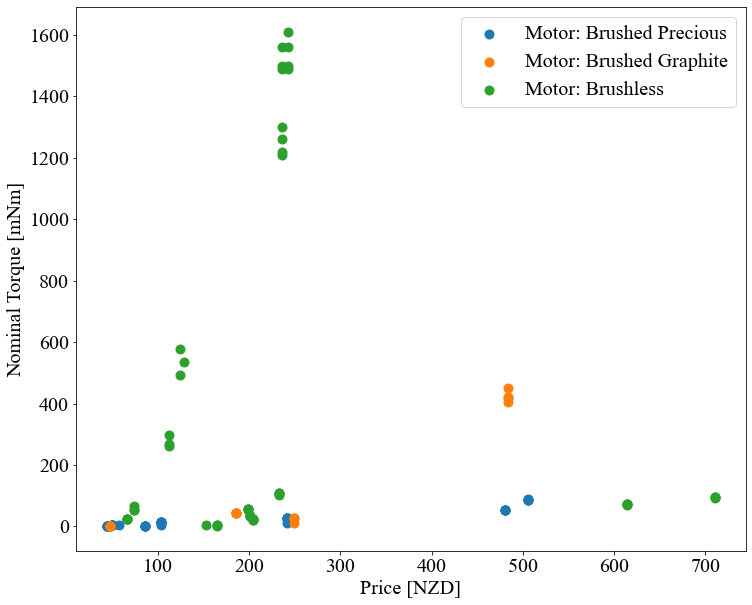

In [10]:
fig3, ax3 = plt.subplots(figsize=(12,10), facecolor='w')
types = maxon_df['Type'].unique()
mapping = ['Brushed Precious', 'Brushed Graphite', 'Brushless']
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, case in enumerate(types):
    df = maxon_df[maxon_df['Type']==case].copy()
    df.sort_values(by=['Price [NZD]'], inplace=True)
    #fit = np.poly1d(np.polyfit(df['Price [NZD]'], df['Nominal Torque [mNm]'], 1))
    ax3.scatter(df['Price [NZD]'], df['Nominal Torque [mNm]'], color=colors[i], label='Motor: ' + mapping[i])
    #ax3.plot(df['Price [NZD]'], fit(df['Price [NZD]']), '--', color=colors[i], label=mapping[i] + ' fit')

ax3.set_xlabel('Price [NZD]')
ax3.set_ylabel('Nominal Torque [mNm]')
#ax3.set_yscale('log')
#ax3.set_xscale('log')
ax3.legend()
fig3.savefig(Path(r'./').joinpath('motor_price.pdf'), facecolor='w', dpi=300, bbox_inches='tight')

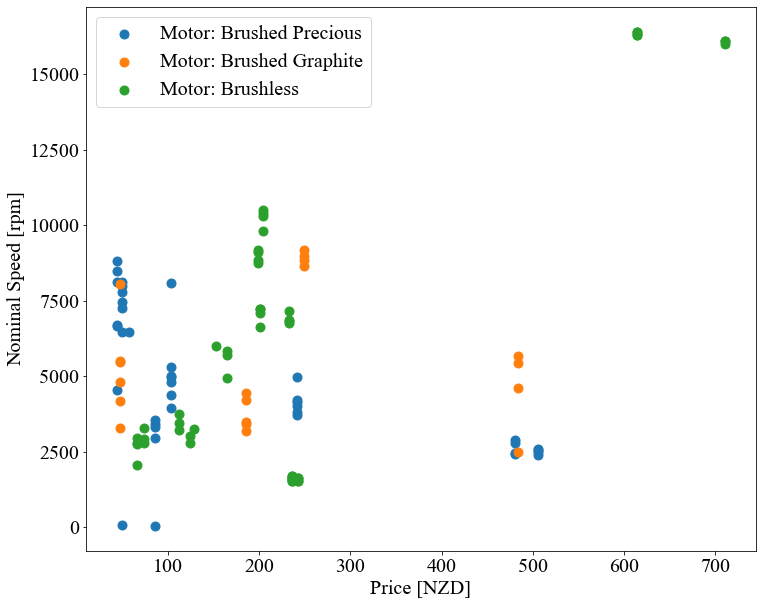

In [11]:
fig3, ax3 = plt.subplots(figsize=(12,10), facecolor='w')
types = maxon_df['Type'].unique()
mapping = ['Brushed Precious', 'Brushed Graphite', 'Brushless']
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, case in enumerate(types):
    df = maxon_df[maxon_df['Type']==case].copy()
    df.sort_values(by=['Price [NZD]'], inplace=True)
    #fit = np.poly1d(np.polyfit(df['Price [NZD]'], df['Nominal Torque [mNm]'], 1))
    ax3.scatter(df['Price [NZD]'], df['Nominal Speed [rpm]'], color=colors[i], label='Motor: ' + mapping[i])
    #ax3.plot(df['Price [NZD]'], fit(df['Price [NZD]']), '--', color=colors[i], label=mapping[i] + ' fit')

ax3.set_xlabel('Price [NZD]')
ax3.set_ylabel('Nominal Speed [rpm]')
#ax3.set_yscale('log')
#ax3.set_xscale('log')
ax3.legend()
fig3.savefig(Path(r'./').joinpath('motor_speed.pdf'), facecolor='w', dpi=300, bbox_inches='tight')

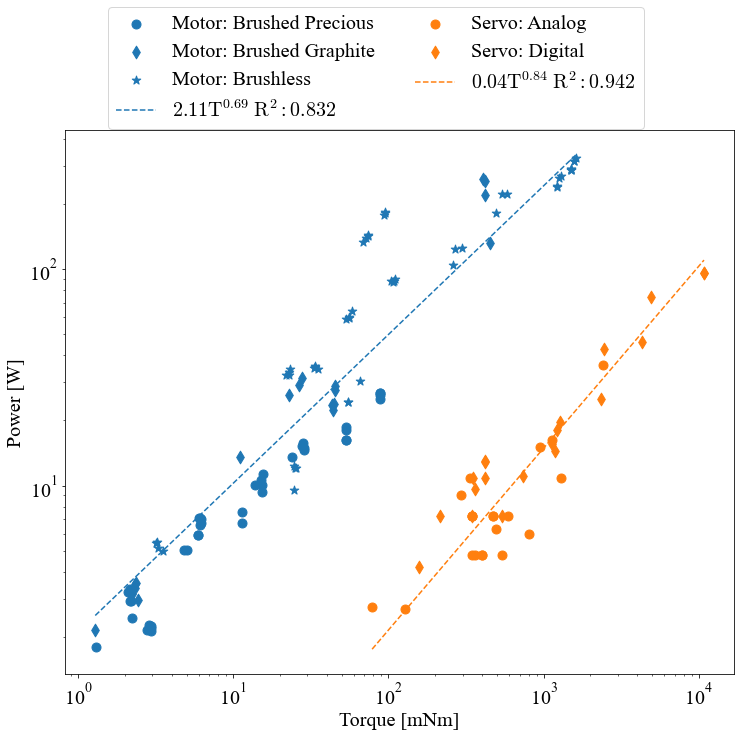

In [8]:
fig4, ax4 = plt.subplots(figsize=(12,10), facecolor='w')
types = maxon_df['Type'].unique()
mapping = ['Brushed Precious', 'Brushed Graphite', 'Brushless']
markers = ['o', 'd', '*']
colors = ['tab:blue', 'tab:orange', 'tab:green']

maxon_df.sort_values(by=['Nominal Torque [mNm]'], inplace=True)
servo_df.sort_values(by=['Torque [mNm]'], inplace=True)

model = PowerLawModel(prefix='p_')
maxon_power = np.multiply(maxon_df['Nominal Voltage [V]'].values, maxon_df['Nominal Current [A]'].values)
pars = model.guess(maxon_power, x=maxon_df['Nominal Torque [mNm]'].values)
pars['p_amplitude'].set(value=0.4, min=0.01, max=2.11)
pars['p_exponent'].set(value=0.5, min=0.25, max=1.0)

maxon_fit = model.fit(maxon_power, pars, x=maxon_df['Nominal Torque [mNm]'].values)

servo_power = np.multiply(servo_df['Nominal Voltage [V]'].values, servo_df['Nominal Current [A]'].values)
pars = model.guess(servo_power, x=servo_df['Torque [mNm]'].values)
pars['p_amplitude'].set(value=0.04, min=0.01, max=0.045)
pars['p_exponent'].set(value=0.52, min=0.25, max=0.84)

servo_fit = model.fit(servo_df['Torque [mNm]'].values, pars, x=servo_df['Torque [mNm]'].values)

r_squared = np.array([calc_rsquared(maxon_df['Nominal Torque [mNm]'].values, maxon_power, maxon_fit.params['p_amplitude'], maxon_fit.params['p_exponent']), 
                      calc_rsquared(servo_df['Torque [mNm]'].values, servo_power, servo_fit.params['p_amplitude'], servo_fit.params['p_exponent'])])

for i, case in enumerate(types):
    df = maxon_df[maxon_df['Type']==case].copy()
    df.sort_values(by=['Nominal Torque [mNm]'], inplace=True)
    power = np.multiply(df['Nominal Voltage [V]'].values, df['Nominal Current [A]'].values)
    ax4.scatter(df['Nominal Torque [mNm]'], power, marker=markers[i], color='C0', label='Motor: ' + mapping[i])

ax4.plot(maxon_df['Nominal Torque [mNm]'].values, maxon_fit.params['p_amplitude'].value*maxon_df['Nominal Torque [mNm]'].values**maxon_fit.params['p_exponent'].value, 'C0' + '--', label='$\mathrm{' + str(np.round(maxon_fit.params['p_amplitude'].value, 2)) + 
        'T^{' + str(np.round(maxon_fit.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(r_squared[0], 3)) + '}$')

servo_types = servo_df['Circuit'].unique()
for i, case in enumerate(servo_types):
    df = servo_df[servo_df['Circuit']==case].copy()
    df.sort_values(by=['Torque [mNm]'], inplace=True)
    power = np.multiply(df['Nominal Voltage [V]'].values, df['Nominal Current [A]'].values)
    ax4.scatter(df['Torque [mNm]'], power, marker=markers[i], color='C1', label='Servo: ' + case)

ax4.plot(servo_df['Torque [mNm]'].values, servo_fit.params['p_amplitude'].value*servo_df['Torque [mNm]'].values**servo_fit.params['p_exponent'].value, 'C1' + '--', label='$\mathrm{' + str(np.round(servo_fit.params['p_amplitude'].value, 2)) + 
        'T^{' + str(np.round(servo_fit.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(r_squared[1], 3)) + '}$')

ax4.set_xlabel('Torque [mNm]')
ax4.set_ylabel('Power [W]')
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.legend(ncol=2, loc=2, bbox_to_anchor=(0.05, 1.245))
#fig4.savefig('motor_torque_power.pdf', facecolor='w', dpi=300, bbox_inches='tight')

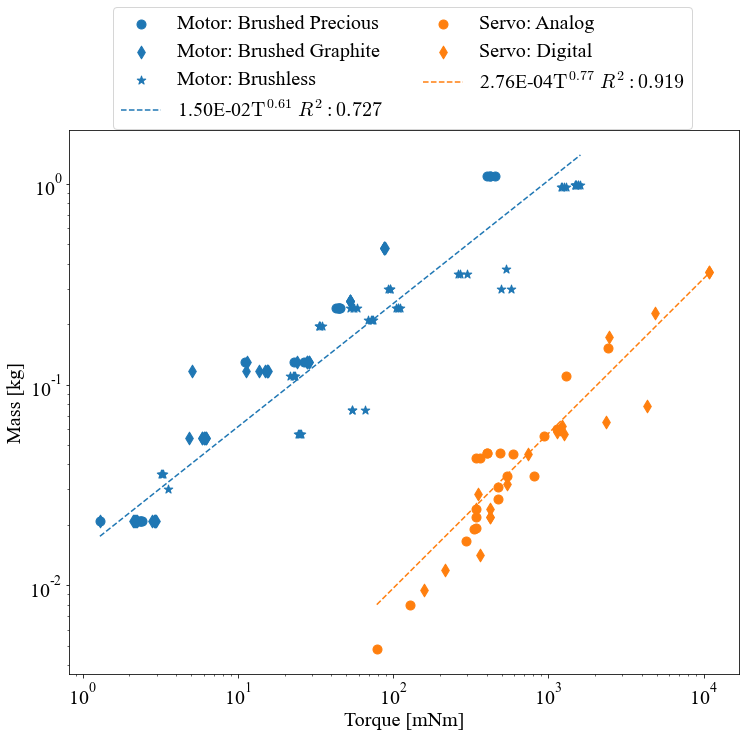

In [52]:
fig5, ax5 = plt.subplots(figsize=(12,10), facecolor='w')
types = maxon_df['Type'].unique()
mapping = ['Brushed Precious', 'Brushed Graphite', 'Brushless']
markers = ['o', 'd', '*']
colors = ['tab:blue', 'tab:orange', 'tab:green']

maxon_df.sort_values(by=['Nominal Torque [mNm]'], inplace=True)
servo_df.sort_values(by=['Torque [mNm]'], inplace=True)

model = PowerLawModel(prefix='p_')
pars = model.guess(maxon_df['Nominal Torque [mNm]'].values, x=maxon_df['Weight [kg]'].values)
pars['p_amplitude'].set(value=1e-3, min=1e-4, max=0.015)
pars['p_exponent'].set(value=0.75, min=0.61, max=0.9)

maxon_fit = model.fit(maxon_df['Nominal Torque [mNm]'].values, pars, x=maxon_df['Weight [kg]'].values)

pars = model.guess(servo_df['Weight [kg]'].values, x=servo_df['Torque [mNm]'].values)
pars['p_amplitude'].set(value=1e-4, min=1e-5, max=0.1)
pars['p_exponent'].set(value=1.0, min=0.5, max=5.0)

servo_fit = model.fit(servo_df['Weight [kg]'].values, pars, x=servo_df['Torque [mNm]'].values)

r_squared = np.array([calc_rsquared(maxon_df['Nominal Torque [mNm]'].values, maxon_df['Weight [kg]'].values, maxon_fit.params['p_amplitude'], maxon_fit.params['p_exponent']), 
                      calc_rsquared(servo_df['Torque [mNm]'].values, servo_df['Weight [kg]'].values, servo_fit.params['p_amplitude'], servo_fit.params['p_exponent'])])

dx = np.linspace(0.1, 1.0, 20)
for i, case in enumerate(types):
    df = maxon_df[maxon_df['Type']==case].copy()
    df.sort_values(by=['Nominal Torque [mNm]'], inplace=True)

    ax5.scatter(df['Nominal Torque [mNm]'], df['Weight [kg]'], marker=markers[i], color='C0', label='Motor: ' + mapping[i])

ax5.plot(maxon_df['Nominal Torque [mNm]'].values, maxon_fit.params['p_amplitude'].value*maxon_df['Nominal Torque [mNm]'].values**maxon_fit.params['p_exponent'].value, 'C0' + '--', label='{:.2E}'.format(maxon_fit.params['p_amplitude'].value) + 
        '$\mathrm{T}^{' + str(np.round(maxon_fit.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(r_squared[0], 3)) + '}$')

servo_types = servo_df['Circuit'].unique()
for i, case in enumerate(servo_types):
    df = servo_df[servo_df['Circuit']==case].copy()
    df.sort_values(by=['Torque [mNm]'], inplace=True)
    ax5.scatter(df['Torque [mNm]'], df['Weight [kg]'], marker=markers[i], color='C1', label='Servo: ' + case)


ax5.plot(servo_df['Torque [mNm]'].values, servo_fit.params['p_amplitude'].value*servo_df['Torque [mNm]'].values**servo_fit.params['p_exponent'].value, 'C1' + '--', label='{:.2E}'.format(servo_fit.params['p_amplitude'].value) + 
        '$\mathrm{T}^{' + str(np.round(servo_fit.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(r_squared[1], 3)) + '}$')

ax5.set_ylabel('Mass [kg]')
ax5.set_xlabel('Torque [mNm]')
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.legend(ncol=2, loc=2, bbox_to_anchor=(0.05, 1.245))
fig5.savefig('motor_mass_torque.pdf', facecolor='w', dpi=300, bbox_inches='tight')